## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator
from sklearn.datasets import fetch_20newsgroups

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, pairwise_distances

from scipy.spatial.distance import cdist
from sklearn.neighbors import KDTree
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS, CountVectorizer as CountVec, TfidfVectorizer as Tfidf
from sklearn.model_selection import cross_val_score
from tqdm import tqdm

### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [2]:
class MyKNeighborsClassifier(BaseEstimator):
    
    def __init__(self, n_neighbors, algorithm='brute', metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.algorithm = algorithm
        self.metric = metric
    
    def fit(self, X, y):
        self.y_train = y
        if self.algorithm == 'brute':
            self.X_train = X
        elif self.algorithm == 'kd_tree':
            self.X_train = KDTree(X)
    
    def predict(self, X):
        if self.algorithm == 'brute':
            dist = pairwise_distances(X, self.X_train, metric=self.metric)
            ind = np.argpartition(dist, self.n_neighbors, axis=1)[:, :self.n_neighbors]
            y = self.y_train[ind.ravel()].reshape(-1, self.n_neighbors)
            res = map(lambda x: np.argmax(np.bincount(x)), y)
            return np.asarray(list(res))
        elif self.algorithm == 'kd_tree':
            ind = self.X_train.query(X, k = self.n_neighbors)[1]
            y = self.y_train[ind.ravel()].reshape(-1, self.n_neighbors)
            res = map(lambda x: np.argmax(np.bincount(x)), y)
            return np.asarray(list(res))
        else:
            return None


**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [3]:
iris = datasets.load_iris()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [5]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [6]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [7]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [12]:
%time clf.fit(X_train, y_train)

Wall time: 0 ns


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [13]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [14]:
%time clf.predict(X_test)

Wall time: 11.7 ms


array([0, 2, 1, 2, 1, 1, 0, 0, 0, 1, 2, 1, 2, 0, 2])

In [15]:
%time my_clf.predict(X_test)

Wall time: 7.99 ms


array([0, 2, 1, 2, 1, 1, 0, 0, 0, 1, 2, 1, 2, 0, 2], dtype=int64)

In [16]:
np.all(clf.predict(X_test) == my_clf.predict(X_test))

True

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [56]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [57]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [58]:
%time clf.fit(X_train, y_train)

Wall time: 2.16 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [59]:
%time my_clf.fit(X_train, y_train)

Wall time: 0 ns


In [60]:
%time clf.predict(X_test)

Wall time: 12.7 ms


array([0, 1, 2, 1, 0, 2, 2, 0, 1, 2, 2, 1, 0, 1, 0])

In [61]:
%time my_clf.predict(X_test)

Wall time: 17.1 ms


array([0, 1, 2, 1, 0, 2, 2, 0, 1, 2, 2, 1, 0, 1, 0], dtype=int64)

In [62]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [63]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [64]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [65]:
vectorizer = CountVec(min_df=5, max_df=0.95, stop_words=ENGLISH_STOP_WORDS)
X = vectorizer.fit_transform(data)

In [66]:
X = X.toarray()
X.shape

(11314, 17797)

*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [67]:
%%time

my_clf = MyKNeighborsClassifier(n_neighbors=2)
cross_val_score(my_clf, X, target, cv=3, scoring="accuracy")

Wall time: 35.7 s


array([0.22613998, 0.20816759, 0.2283214 ])

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [68]:
nums = range(1, 11)
results = []
for k in tqdm(nums):
    my_clf = MyKNeighborsClassifier(n_neighbors=k)
    results.append(np.mean(cross_val_score(my_clf, X, target, cv=3, scoring="accuracy")))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:25<00:00, 32.59s/it]


1

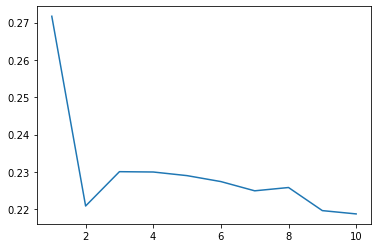

In [69]:
import matplotlib.pyplot as plt
plt.plot(range(1, 11), results)
np.argmax(results) + 1

Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

In [70]:
nums = range(1, 11)
results = []
for k in tqdm(nums):
    my_clf = MyKNeighborsClassifier(n_neighbors=k, metric='cosine')
    results.append(np.mean(cross_val_score(my_clf, X, target, cv=3, scoring="accuracy")))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [07:39<00:00, 45.99s/it]


10

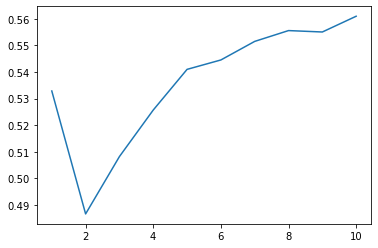

In [71]:
plt.plot(range(1, 11), results)
np.argmax(results) + 1

In [72]:
vectorizer = Tfidf(min_df=5, max_df=0.95, stop_words=ENGLISH_STOP_WORDS)
X = vectorizer.fit_transform(data)

In [73]:
X = X.toarray()
X.shape

(11314, 17797)

In [74]:
nums = range(1, 11)
results = []
for k in tqdm(nums):
    my_clf = MyKNeighborsClassifier(n_neighbors=k, metric='cosine')
    results.append(np.mean(cross_val_score(my_clf, X, target, cv=3, scoring="accuracy")))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [05:34<00:00, 33.42s/it]


10

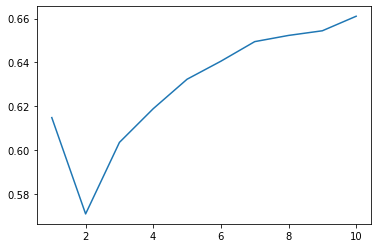

In [75]:
plt.plot(range(1, 11), results)
np.argmax(results) + 1

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [76]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

In [78]:
X_test = vectorizer.transform(newsgroups.data)
X_test = X_test.toarray()

In [79]:
my_clf = MyKNeighborsClassifier(n_neighbors=11, metric='cosine')
my_clf.fit(X, target)
accuracy_score(my_clf.predict(X_test), newsgroups.target)

0.5973181093998938

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

Косинусная метрика вместе с tfidf векторизацией показала наилучший результат. Это может быть связано с тем, что мы учитываем частотность слов в документах. Точность на тестовой выборке несколько меньше, чем на кросс-валидации, потому что при кросс-валидации мы берем среднее значения на фолдах и наборы слов в train и test части могут отличаться.